In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Static Pressure graph

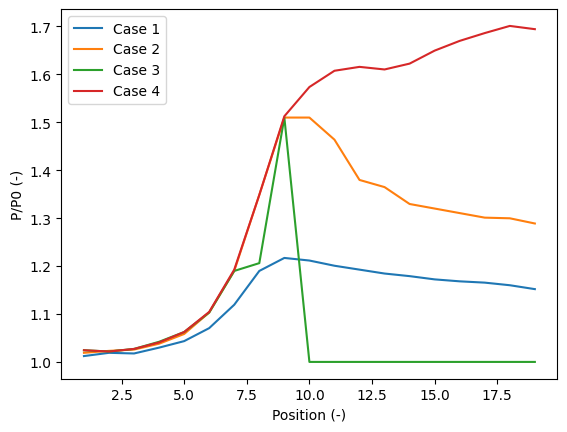

In [7]:
C1 = np.loadtxt('case1.txt', skiprows=1)
C2 = np.loadtxt('case2.txt', skiprows=1)
C3 = np.loadtxt('case3.txt', skiprows=1)
C4 = np.loadtxt('case4.txt', skiprows=1)

plt.plot(C1[:,0], C1[:,-1], label='Case 1')
plt.plot(C2[:,0], C2[:,-1], label='Case 2')
plt.plot(C3[:,0], C3[:,-1], label='Case 3')
plt.plot(C4[:,0], C4[:,-1], label='Case 4')

plt.xlabel('Position (-)')
plt.ylabel('P/P0 (-)')
plt.legend()

plt.show()

# Mach number graph